### Imports

In [2]:
import ssl
from my_utils.data_preprocess import *
from my_utils.input_data import *
# Read the dataset description
import gzip
# Read or generate p2h, a dictionary of image name to image id (picture to hash)
import pickle
import platform
import random
# Suppress annoying stderr output when importing keras.
import sys, os
from lapjv import lapjv
from math import sqrt
# Determine the size of each image
from os.path import isfile
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image as pil_image
from imagehash import phash
from pandas import read_csv
from scipy.ndimage import affine_transform
from tqdm import tqdm
import time
from keras import backend as K
from keras import regularizers
from keras.engine.topology import Input
from keras.layers import Activation, Add, BatchNormalization, Concatenate, Conv2D, Dense, Flatten, GlobalMaxPooling2D, \
	Lambda, MaxPooling2D, Reshape
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from keras.utils import Sequence
from keras.models import Sequential, load_model
from base_fns import get_local_folder
ssl._create_default_https_context = ssl._create_unverified_context # needed for model downloading



/Users/elenadegtyar/PycharmProjects/humpbackid
/Users/elenadegtyar/PycharmProjects/humpbackid/data/train 
 /Users/elenadegtyar/PycharmProjects/humpbackid/data/test 
 /Users/elenadegtyar/PycharmProjects/humpbackid/data/train.csv 
 /Users/elenadegtyar/PycharmProjects/humpbackid/data/sample_submission.csv 
 /Users/elenadegtyar/PycharmProjects/humpbackid/data/p2h.pickle 
 /Users/elenadegtyar/PycharmProjects/humpbackid/data/bounding_boxes.csv 
 <class 'str'>
The number of train data image files is 25361
The number of test data image files is 7960
The number of train and test data image files is 33321
P2SIZE exists.
P2H exists.
The length of p2h is 33321
The first five elements of p2h-dict [('0000e88ab.jpg', 'd26698c3271c757c'), ('0001f9222.jpg', 'ba8cc231ad489b77'), ('00029d126.jpg', 'bbcad234a52d0f0b'), ('00050a15a.jpg', 'c09ae7dc09f33a29'), ('0005c1ef8.jpg', 'd02f65ba9f74a08a')]
The length of h2ps is 33317
The length of h2p is 33317
The first five elements of h2p-list [('d26698c3271c757c'

Using TensorFlow backend.


/Users/elenadegtyar/PycharmProjects/humpbackid


### Init model

In [3]:
from keras import regularizers
from keras.engine.topology import Input
from keras.layers import Activation, Add, BatchNormalization, Concatenate, Conv2D, Dense, Flatten, GlobalMaxPooling2D, \
    Lambda, GlobalAveragePooling2D, MaxPooling2D, Reshape, Dropout
from keras.applications.densenet import DenseNet121
from keras.applications.resnet50 import ResNet50

from keras.models import Model
from keras.optimizers import Adam
from keras import backend as K

img_shape = (512, 512, 1)  # 模型使用的图像形状


# ResNet V2: shortcut connection structure
def subblock(x, filter, **kwargs):
    x = BatchNormalization()(x)
    y = x
    y = Conv2D(filter, (1, 1), activation='relu', **kwargs)(y)  # Reduce the number of features to 'filter'
    y = BatchNormalization()(y)
    y = Conv2D(filter, (3, 3), activation='relu', **kwargs)(y)  # Extend the feature field
    y = BatchNormalization()(y)
    y = Conv2D(K.int_shape(x)[-1], (1, 1), **kwargs)(y)  # no activation # Restore the number of original features
    y = Add()([x, y])  # Add the bypass connection
    y = Activation('relu')(y)
    return y


def build_model(lr, l2, activation='sigmoid'):
    #################################
    # BRANCH MODEL,提取输入图像的特征向量
    #################################
    regul = regularizers.l2(l2)
    optim = Adam(lr=lr)
    kwargs = {'padding': 'same', 'kernel_regularizer': regul}

    inp = Input(shape=img_shape)  # 384x384x1
    x = Conv2D(64, (9, 9), strides=2, activation='relu', **kwargs)(inp)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x)  # 96x96x64
    for _ in range(2):
        x = BatchNormalization()(x)
        x = Conv2D(64, (3, 3), activation='relu', **kwargs)(x)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x)  # 48x48x64
    x = BatchNormalization()(x)
    x = Conv2D(128, (1, 1), activation='relu', **kwargs)(x)  # 48x48x128
    for _ in range(4):
        x = subblock(x, 64, **kwargs)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x)  # 24x24x128
    x = BatchNormalization()(x)
    x = Conv2D(256, (1, 1), activation='relu', **kwargs)(x)  # 24x24x256
    for _ in range(4):
        x = subblock(x, 64, **kwargs)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x)  # 12x12x256
    x = BatchNormalization()(x)
    x = Conv2D(384, (1, 1), activation='relu', **kwargs)(x)  # 12x12x384
    for _ in range(4):
        x = subblock(x, 96, **kwargs)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x)  # 6x6x384
    x = BatchNormalization()(x)
    x = Conv2D(512, (1, 1), activation='relu', **kwargs)(x)  # 6x6x512
    for _ in range(4):
        x = subblock(x, 128, **kwargs)

    x = GlobalMaxPooling2D()(x)  # 512
    branch_model = Model(inp, x)

    #######################################
    # HEAD MODEL,比较来自branch_model的特征向量
    #######################################
    mid = 32
    xa_inp = Input(shape=branch_model.output_shape[1:])
    xb_inp = Input(shape=branch_model.output_shape[1:])
    x1 = Lambda(lambda x: x[0] * x[1])([xa_inp, xb_inp])
    x2 = Lambda(lambda x: x[0] + x[1])([xa_inp, xb_inp])
    x3 = Lambda(lambda x: K.abs(x[0] - x[1]))([xa_inp, xb_inp])
    x4 = Lambda(lambda x: K.square(x))(x3)
    x = Concatenate()([x1, x2, x3, x4])
    x = Reshape((4, branch_model.output_shape[1], 1), name='reshape1')(x)

    # 使用合适的步幅，让2D卷积实现具有共享权重的特征神经网络
    x = Conv2D(mid, (4, 1), activation='relu', padding='valid')(x)
    x = Reshape((branch_model.output_shape[1], mid, 1))(x)
    x = Conv2D(1, (1, mid), activation='linear', padding='valid')(x)
    x = Flatten(name='flatten')(x)

    # Dense layer的实现为加权和
    x = Dense(1, use_bias=True, activation=activation, name='weighted-average')(x)
    head_model = Model([xa_inp, xb_inp], x, name='head')

    ########################
    # SIAMESE NEURAL NETWORK
    ########################
    # 通过在每个输入图像上调用branch model来构建完整模型,
    # 然后是生成512个向量的head model.
    img_a = Input(shape=img_shape)
    img_b = Input(shape=img_shape)
    xa = branch_model(img_a)
    xb = branch_model(img_b)
    x = head_model([xa, xb])
    model = Model([img_a, img_b], x)

    model.compile(optim, loss='binary_crossentropy', metrics=['binary_crossentropy', 'acc'])

    return model, branch_model, head_model

In [4]:
# important functions
def read_cropped_image(p, augment):
	"""
	@param p : 要读取的图片的名称
	@param augment: 是否需要做图像增强
	@返回变换后的图像
	"""
	# 如果给出了图像ID，则转换为文件名
	if p in h2p:
		p = h2p[p]
	size_x, size_y = p2size[p]

	# 根据边界框确定要捕获的原始图像的区域
	row = p2bb.loc[p]  # 返回image的标定框值--DataFrame
	x0, y0, x1, y1 = row['x0'], row['y0'], row['x1'], row['y1']
	dx = x1 - x0
	dy = y1 - y0
	# 为边框添加空白值,重新设置(x0,x1,y0,y1)
	x0 -= dx * crop_margin
	x1 += dx * crop_margin + 1
	y0 -= dy * crop_margin
	y1 += dy * crop_margin + 1
	if x0 < 0:
		x0 = 0
	if x1 > size_x:
		x1 = size_x
	if y0 < 0:
		y0 = 0
	if y1 > size_y:
		y1 = size_y
	# 计算鲸鱼尾巴ROI的长宽值
	dx = x1 - x0
	dy = y1 - y0
	# 重新计算(x0,x1,y0,y1)，使得水平压缩比anisotropy等于初始化值2.15
	# dx过大,则增加dy
	if dx > dy * anisotropy:
		dy = 0.5 * (dx / anisotropy - dy)
		y0 -= dy
		y1 += dy
	# dy过大,则增加dx
	else:
		dx = 0.5 * (dy * anisotropy - dx)
		x0 -= dx
		x1 += dx

	# 生成随机变换矩阵(增强图像矩阵)
	trans = np.array([[1, 0, -0.5 * img_shape[0]], [0, 1, -0.5 * img_shape[1]], [0, 0, 1]])
	trans = np.dot(np.array([[(y1 - y0) / img_shape[0], 0, 0], [0, (x1 - x0) / img_shape[1], 0], [0, 0, 1]]), trans)
	if augment:
		trans = np.dot(build_transform(
			random.uniform(-5, 5),
			random.uniform(-5, 5),
			random.uniform(0.8, 1.0),
			random.uniform(0.8, 1.0),
			random.uniform(-0.05 * (y1 - y0), 0.05 * (y1 - y0)),
			random.uniform(-0.05 * (x1 - x0), 0.05 * (x1 - x0))
		), trans)
	trans = np.dot(np.array([[1, 0, 0.5 * (y1 + y0)], [0, 1, 0.5 * (x1 + x0)], [0, 0, 1]]), trans)

	# 读取图像,转化为numpy数组
	img = read_raw_image(p).convert('L')
	img = np.asarray(img)
	# print('original shape:',img.shape)
	# 应用放射变换, 矩阵计算实际在这里
	matrix = trans[:2, :2]
	offset = trans[:2, 2]
	img_affine = affine_transform(img, matrix, offset, order=1, output_shape=img_shape[:-1], mode='constant',
								cval=np.average(img))
	# print('after affine_transform shape:',img_affine.shape)
	# 将3个二维数组重叠为一个三维数组

	img = np.asarray(img_affine, 'f')

	# 归一化为零均值和方差
	img -= np.mean(img, keepdims=True)
	img /= np.std(img, keepdims=True) + K.epsilon()
	img = np.expand_dims(img, axis=-1)

	return img

### Load the pretrained model

In [5]:
# Load the model
model_path = Path(get_local_folder()) / "model"/ "standard_epoch350.h5"
print(model_path, isfile(model_path))

model, branch_model, head_model = build_model(64e-5, 0)

model.summary()

if isfile(model_path):
	model.load_weights(model_path) # add
	print('Load model success!')
else:
	print('The model file is not exist!')

def expand_path(p):
    if isfile(os.path.join(TRAIN, p)):
        return os.path.join(TRAIN, p)
    if isfile(os.path.join(TEST, p)):
        return os.path.join(TEST, p)
    return p

/Users/elenadegtyar/PycharmProjects/humpbackid/model/standard_epoch350.h5 True
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 512)          2692096     input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
head (Model)                  

### Obtain features for known whales

In [6]:
# Find elements from training sets not 'new_whale'
tic = time.time()
h2ws = {}
for p, w in tagged.items():
	if w != new_whale:  # Use only identified whales
		h = p2h[p]
		if h not in h2ws: h2ws[h] = []
		if w not in h2ws[h]: h2ws[h].append(w)
known = sorted(list(h2ws.keys()))
print("Number of pictures of known whales: ", len(known))
# only run if there is no features_txt data in data folder
#fknown = branch_model.predict_generator(FeatureGen(known), max_queue_size=10, workers=1, verbose=0)
#np.savetxt(Path(get_local_folder()) / "data"/ "features_known_new.csv", fknown, delimiter = ",")


Number of pictures of known whales:  15696


In [7]:
# read the saved generated features
fknown = np.loadtxt(str(Path(get_local_folder()) / "data"/ "features_known_new.csv"), delimiter = ",")

### Get prediction for the image

In [8]:
def score_reshape(score, x, y=None):
	"""
	Tranformed the packed matrix 'score' into a square matrix.
	@param score the packed matrix
	@param x the first image feature tensor
	@param y the second image feature tensor if different from x
	@result the square matrix
	"""
	if y is None:
		# When y is None, score is a packed upper triangular matrix.
		# Unpack, and transpose to form the symmetrical lower triangular matrix.
		m = np.zeros((x.shape[0], x.shape[0]), dtype=K.floatx())
		m[np.triu_indices(x.shape[0], 1)] = score.squeeze()
		m += m.transpose()
	else:
		m = np.zeros((y.shape[0], x.shape[0]), dtype=K.floatx())
		iy, ix = np.indices((y.shape[0], x.shape[0]))
		ix = ix.reshape((ix.size,))
		iy = iy.reshape((iy.size,))
		m[iy, ix] = score.squeeze()
	return m

### Predict using preimplemented functions

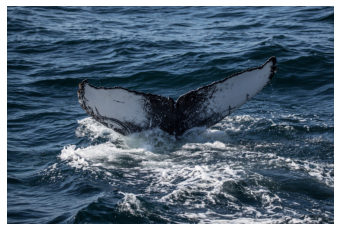

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt
img = read_raw_image("0000e88ab.jpg")
plt.figure()
plt.imshow(img)  # Convert from tensor to numpy array and rearrange channels
plt.axis('off')
plt.show()

In [10]:
tic = time.time()
h2ws = {}
for p, w in tagged.items():
	if w != new_whale:  # Use only identified whales
		h = p2h[p]
		if h not in h2ws: h2ws[h] = []
		if w not in h2ws[h]: h2ws[h].append(w)
known = sorted(list(h2ws.keys()))

img_orig_name = "0000e88ab.jpg"
fsubmit = branch_model.predict_generator(FeatureGen([img_orig_name]), max_queue_size=20, workers=1, verbose=0)
score = head_model.predict_generator(ScoreGen(fknown, fsubmit), max_queue_size=20, workers=10, verbose=0)
score = score_reshape(score, fknown, fsubmit)
score = np.array(score).squeeze()
print(score)
# Find top 5 closest whales as in challenge
best_match_indexes = np.argsort(score)[::-1][:5]

predicted_whales = []
for match_id in best_match_indexes:
	print(match_id)
	predicted_whales.append(h2ws.get(known[match_id]))

print("Top 5 possible predicted whales:", predicted_whales)
prediction_match = True if h2ws.get(p2h.get(img_orig_name)) in predicted_whales else False

print("Prediction is", str(prediction_match))
print("Right whale is ", str(h2ws.get(p2h.get(img_orig_name))))

Scores: 100%|██████████| 8/8 [00:00<00:00, 237.28it/s]


[4.6142263e-06 3.8274817e-11 1.6566540e-13 ... 1.6600084e-11 9.5454139e-05
 2.6378136e-10]
9014
1445
3844
880
4076
Top 5 possible predicted whales: [['w_f48451c'], ['w_f48451c'], ['w_f48451c'], ['w_f48451c'], ['w_f48451c']]
Prediction is True
Right whale is  ['w_f48451c']


### Predict using self-made code

In [11]:
tic = time.time()
h2ws = {}
for p, w in tagged.items():
	if w != new_whale:  # Use only identified whales
		h = p2h[p]
		if h not in h2ws: h2ws[h] = []
		if w not in h2ws[h]: h2ws[h].append(w)
known = sorted(list(h2ws.keys()))
img_orig_name = "0000e88ab.jpg"
# preprocess the image
img = read_cropped_image(img_orig_name , False)
# Extract features using branch_model
img_features = branch_model.predict(np.array([img]))

# Compare with database images
scores = []
for known_feature in tqdm(fknown):
	score = head_model.predict([img_features, np.array([known_feature])])
	scores.append(score)
scores = np.asarray(scores).squeeze()
# Find top 5 closest whales as in challenge
best_match_indexes = np.argsort(scores)[::-1][:5]

predicted_whales = []
for match_id in best_match_indexes:
	predicted_whales.append(h2ws.get(known[match_id]))

print("Top 5 possible predicted whales:", predicted_whales)
prediction_match = True if h2ws.get(p2h.get(img_orig_name)) in predicted_whales else False

print("Prediction is", str(prediction_match))
print("Right whale is ", str(h2ws.get(p2h.get(img_orig_name))))

 67%|██████▋   | 10475/15696 [00:44<00:22, 233.08it/s]


KeyboardInterrupt: 

## Interpretation with Occlusion

## Interpretation with Saliency

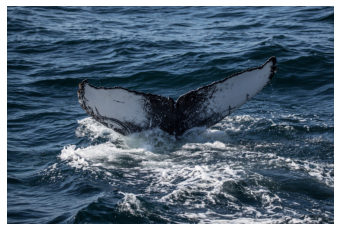

In [47]:
%matplotlib inline

import matplotlib.pyplot as plt
img = read_raw_image("0000e88ab.jpg")
plt.figure()
plt.imshow(img)  # Convert from tensor to numpy array and rearrange channels
plt.axis('off')
plt.show()

In [48]:
# Ensure 'index' is correctly identified
layer_names = [layer.name for layer in branch_model.layers]
layers = [layer for layer in branch_model.layers]
index = 0
for idx, layer in enumerate(branch_model.layers):
    if layer.name == 'global_max_pooling2d_2':
        index = idx
        break
print(layer_names)

#last convolutional layer
last_cv_layer_output= layers[layer_names.index("conv2d_55")].output

['input_1', 'conv2d_1', 'max_pooling2d_1', 'batch_normalization_1', 'conv2d_2', 'batch_normalization_2', 'conv2d_3', 'max_pooling2d_2', 'batch_normalization_3', 'conv2d_4', 'batch_normalization_4', 'conv2d_5', 'batch_normalization_5', 'conv2d_6', 'batch_normalization_6', 'conv2d_7', 'add_1', 'activation_1', 'batch_normalization_7', 'conv2d_8', 'batch_normalization_8', 'conv2d_9', 'batch_normalization_9', 'conv2d_10', 'add_2', 'activation_2', 'batch_normalization_10', 'conv2d_11', 'batch_normalization_11', 'conv2d_12', 'batch_normalization_12', 'conv2d_13', 'add_3', 'activation_3', 'batch_normalization_13', 'conv2d_14', 'batch_normalization_14', 'conv2d_15', 'batch_normalization_15', 'conv2d_16', 'add_4', 'activation_4', 'max_pooling2d_3', 'batch_normalization_16', 'conv2d_17', 'batch_normalization_17', 'conv2d_18', 'batch_normalization_18', 'conv2d_19', 'batch_normalization_19', 'conv2d_20', 'add_5', 'activation_5', 'batch_normalization_20', 'conv2d_21', 'batch_normalization_21', 'conv

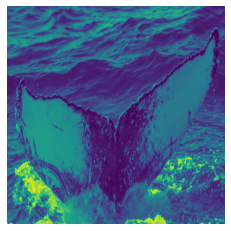

(512, 512, 1)


In [52]:
import tensorflow as tf
img_orig_name = "0000e88ab.jpg"
# preprocess the image
img = read_cropped_image(img_orig_name , False)
plt.imshow(img)
plt.axis('off')
plt.show()
print(img.shape)

# base generated by chatgpt

import tensorflow as tf
import numpy as np

from keras import backend as K
import numpy as np

# structure generated by chat_gpt
def compute_saliency_map_keras(mdl, image, lr_output):
    """
    Compute the saliency map for a given image using Keras backend, adjusted for models with multiple inbound nodes.

    Parameters:
    - mdl: The Keras model.
    - image: The input image as a numpy array of shape (H, W, C).
    - lr_output: Layer output to use for gradient calculation

    Returns:
    - saliency_map: A numpy array representing the saliency map.
    """
    # Ensure image has the correct shape (H, W, C) -> (1, H, W, C)
    if len(image.shape) == 3:
        image = np.expand_dims(image, axis=0)

    # Adjusted to use get_output_at for accessing model's output
    output =  lr_output # Assuming last usage in case of multiple uses

    # Continue as before
    preds = mdl.predict(image)
    class_idx = np.argmax(preds[0])


    # Adjusted to use get_input_at for accessing model's input
    input_img = mdl.get_input_at(0)  # Assuming first usage in case of multiple uses

    # Get the gradients of the output w.r.t. the inputs
    grads = K.gradients(output, input_img)[0]

    # Function to compute the gradients and the output given an input
    grad_func = K.function([input_img], [grads, output])

    # Compute the values
    grad_values, output_values = grad_func([image])

    # Processing the gradients to generate a saliency map
    saliency_map = np.abs(grad_values)[0]
    saliency_map = np.max(saliency_map, axis=-1)

    return saliency_map




saliency_map = compute_saliency_map_keras(branch_model, img, last_cv_layer_output)



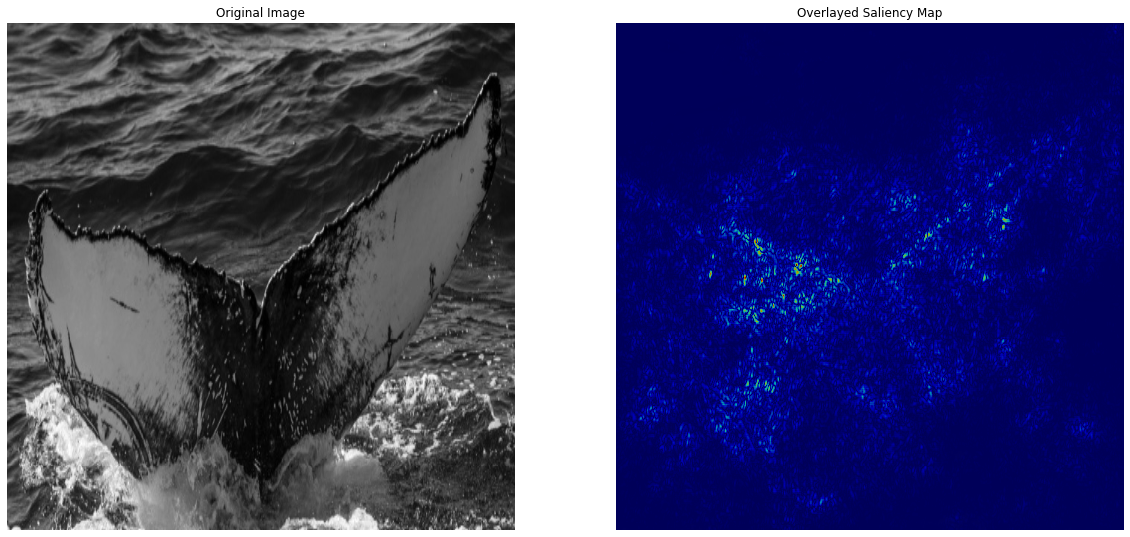

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# generated by chatgpt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

def overlay_saliency_map_on_image(image, saliency_map):
    """
    Overlays the saliency map on the original image.

    Parameters:
    - image: The original image as a numpy array of shape (H, W, C).
    - saliency_map: The saliency map as a numpy array of shape (H, W).

    Note: The original image and the saliency map must have the same spatial dimensions.
    """

    # Ensure the saliency map has the same height and width as the original image
    assert image.shape[:2] == saliency_map.shape[:2], "Image and saliency map must have the same dimensions."

    # Normalize the saliency map for better visualization
    saliency_map_normalized = saliency_map - np.min(saliency_map)
    if np.max(saliency_map_normalized) > 0:
        saliency_map_normalized = saliency_map_normalized / np.max(saliency_map_normalized)

    # Convert the saliency map to a heatmap
    heatmap = cm.jet(saliency_map_normalized)[:, :, :3]  # Use jet colormap; ignore alpha channel

    # Overlay the heatmap onto the original image
    overlayed_image = (heatmap * 255 * 0.7 + image * 0.3).astype(np.uint8)

    # Display the original image and the overlayed image
    plt.figure(figsize=(20, 20))

    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray', interpolation='nearest')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(overlayed_image, interpolation='nearest')
    plt.title('Overlayed Saliency Map')
    plt.axis('off')

    plt.show()

# preprocess the image
img = read_cropped_image(img_orig_name , False)
overlay_saliency_map_on_image(img, saliency_map)
